In [102]:
import pandas as pd
import numpy as np
import dalex as dx

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

## Ładowanie danych
Załadowanie danych dotyczących przeżywalności pasażerów najpopularniejszej katastrofy statku pasażerskiego na świecie. Dane ściągamy wykorzystując [api](https://github.com/Kaggle/kaggle-api) udostępnione przez serwis kaggle.com .

In [2]:
!kaggle competitions download -c titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip -o titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [4]:
df = pd.read_csv('./train.csv', index_col='PassengerId')
df.reset_index(inplace=True)

df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)

## Opis załadowanych featerów

| Name | Description | Info |
| --- | --- | --- |
| PassengerId | id |
| Survived | Survival | 0 = No, 1 = Yes |
| Pclass | Ticket   | class 1 = 1st, 2 = 2nd, 3 = 3rd |
| Sex	 |Sex	
| Age | Age in years |
| SibSp | number of siblings / spouses aboard the Titanic |
|Parch | number of parents / children aboard the Titanic |
| Fare | Passenger fare |
| Ticket | Ticket number |
| Cabin | Cabin number |
| Embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton

## 1 Trenowanie modelu

In [5]:
continous_columns = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_columns = [ 'Pclass',  'Sex']

model_columns = continous_columns + categorical_columns
    
X_train, y_train = df_train[model_columns], df_train['Survived']
X_test, y_test = df_test[model_columns], df_test['Survived']



preprocess = make_column_transformer((StandardScaler(), [model_columns.index(col) for col in continous_columns]),
                                     (OrdinalEncoder(), [model_columns.index(col) for col in categorical_columns]))
lgbm = LGBMClassifier(max_depth=4)

model = make_pipeline(preprocess, lgbm)
model.fit(X_train,y_train, lgbmclassifier__categorical_feature=[model_columns.index(col) for col in categorical_columns])

/home/azapala/.local/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  [0, 1, 2, 3]),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(), [4, 5])])),
                ('lgbmclassifier', LGBMClassifier(max_depth=4))])

In [6]:
train_preds = model.predict_proba(X_train)[:,1]
test_preds = model.predict_proba(X_test)[:,1]

print("Roc auc train:", roc_auc_score(y_train, train_preds))
print("Roc auc test:", roc_auc_score(y_test, test_preds))

Roc auc train: 0.9477505553161159
Roc auc test: 0.9120923913043479


Wytrenowałem model za pomocą biblioteki lightgbm wykorzystujący technikę gradient boosting tree. Model osiągnął sensowne rezultaty na zbiorze treningowym i testowym. 

## 2 Predykcje dla 3 wybranych pasażerów

In [7]:
passanger_index = [60, 250, 512]

In [8]:
df_train.iloc[passanger_index, :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
60,61,0,3,"Sirayanian, Mr. Orsen",male,22.0,0,0,2669,7.2292,NaN,C
250,251,0,3,"Reed, Mr. James George",male,NaN,0,0,362316,7.2500,NaN,S
512,513,1,1,"McGough, Mr. James Robert",male,36.0,0,0,PC 17473,26.2875,E25,S


In [9]:
df_selected = df_train.iloc[passanger_index, :]

In [10]:
df_selected['preds'] = model.predict_proba(df_selected[model_columns])[:, 1]

<ipython-input-10-92052e97f0d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['preds'] = model.predict_proba(df_selected[model_columns])[:, 1]


In [11]:
df_selected

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,preds
60,61,0,3,"Sirayanian, Mr. Orsen",male,22.0,0,0,2669,7.2292,NaN,C,0.205812
250,251,0,3,"Reed, Mr. James George",male,NaN,0,0,362316,7.2500,NaN,S,0.027942
512,513,1,1,"McGough, Mr. James Robert",male,36.0,0,0,PC 17473,26.2875,E25,S,0.785827


Szacowane prawdopdobienstwa przeżycia 3 wybrancyh osób znacząco się różnią.

## 3. Dekompozycja predykcji
Wykorzystując methodę break down oraz shap. 

In [12]:
explainer = dx.Explainer(model, X_train, y_train, verbose=0)

In [ ]:
for i, row in df_selected.iterrows():
    for t in ['shap', 'break_down']:
        explainer_res = explainer.predict_parts(row[model_columns], type=t)
        explainer_res.plot(title=f"{row.Name}, method: {t}")

![](3_examples.png)

## 4. Dwie obserwacje o różnych najważniejszych cechach

In [14]:
def plot_shap_for_observation(df, i, explainer):
    shap_res = explainer.predict_parts(df.iloc[i, :], type='shap')
    shap_res.plot()

In [ ]:
plot_shap_for_observation(df_train[model_columns], 7, explainer)

![](2.png)

In [ ]:
plot_shap_for_observation(df_train[model_columns], 1, explainer)

![](3.png)

Dla obserwacji 7 najważniejszymi cechami jest SibSp oraz Age (liczba rodzeństwa na pokładzie i wiek), natomiast dla obserwacji 1 Sex i Pclass (płeć i klasa).

### Wyjaśnienie dla obserwacji 7:

In [53]:
print("Średnia przeżywalność dla całych danych", df_train.Survived.mean())

Średnia przeżywalność dla całych danych 0.3904494382022472


In [241]:
for feature_name, value in df_train.iloc[7,:].items():
    if feature_name in model_columns:
        if feature_name in ['Age']:
            df_feature = df_train[df_train[feature_name] <= value]
        else:
            df_feature = df_train[df_train[feature_name] == value]
            
        print(f"Nazwa cechy:{feature_name}, % Survived : {df_feature.Survived.mean()}, Liczność:  {len(df_feature)}")

Nazwa cechy:Pclass, % Survived : 0.25384615384615383, Liczność:  390
Nazwa cechy:Sex, % Survived : 0.19298245614035087, Liczność:  456
Nazwa cechy:Age, % Survived : 0.5555555555555556, Liczność:  18
Nazwa cechy:SibSp, % Survived : 0.21428571428571427, Liczność:  14
Nazwa cechy:Parch, % Survived : 0.5108695652173914, Liczność:  92
Nazwa cechy:Fare, % Survived : 0.0, Liczność:  4


Dla obserwacji siódmej istotną cechą jest liczba rodzeńśtwa. Ma ona negatywny wpływ na wynik oraz jest rzadko reprezentowana w datasecie, stąd modyfikacja w całym datasecie SibSp na 3 może znacznie obiniżyć średnią odpowiedź modelu. Młody wiek podnosi szanse przeżycia. W tym przypadku również mamy do czynienia ze stosunkową mała grupą, która tym razem charakteryzuje się wysoką szansą przeżycia, stąd dodatnia atrybucja.

### Wyjaśnienie dla obserwacji 1:

In [52]:
for feature_name, value in df_train.iloc[1,:].items():
    if feature_name in model_columns:
        df_feature = df_train[df_train[feature_name] == value]
        print(f"Nazwa cechy:{feature_name}, % Survived : {df_feature.Survived.mean()}, Liczność:  {len(df_feature)}")

Nazwa cechy:Pclass, % Survived : 0.6114285714285714, Liczność:  175
Nazwa cechy:Sex, % Survived : 0.7421875, Liczność:  256
Nazwa cechy:Age, % Survived : 0.4444444444444444, Liczność:  9
Nazwa cechy:SibSp, % Survived : 0.5266272189349113, Liczność:  169
Nazwa cechy:Parch, % Survived : 0.35911602209944754, Liczność:  543
Nazwa cechy:Fare, % Survived : 1.0, Liczność:  1


Dla obserwacji pierwszej dwoma najważniejszymi cechami jest Pclass i Sex. Średnia przeżywalność dla kobiet wynosi aż 0.74, a dla pasażerów z klasy pierwszej 0.61. Z przykładów w podpunkcie 3 te dwie cechy zawsze występowały jako najważniejsze wraz z Fare, który jest skorelowany z Pclass, droższy bilet z reguły odpowiadał wyższej klasie.

## 5 Dwie obserwacje o przeciwnych wartościach atrybucji

Dla cechy Pclass i wartości 2, odszukałem dwie obserwacje w których ta cecha o tej wartosci ma wpływ pozytywny a w drugiej negatywny.

In [ ]:
for i in range(122, 124):
    plot_shap_for_observation(df_train[model_columns], i, explainer)    

![](4.png)

### Wyjaśnienie zmiany wpływu klasy drugiej na model

In [67]:
print("Średnia przeżywalność dla całych danych", df_train.Survived.mean())

Średnia przeżywalność dla całych danych 0.3904494382022472


In [65]:
df_train.groupby('Pclass')['Survived'].agg(['mean','count']).rename(columns={'mean':'% Survived', 'count':'Liczba obserwacji'})

,% Survived,Liczba obserwacji
Pclass,,
1,0.611429,175
2,0.489796,147
3,0.253846,390


W ogólności dla całych danych cecha Pclass o wartości ma pozytywny wpływ na przeżywalność. Średnia przeżywalność w tej grupie jest większe o ~0.09. 

In [69]:
df_female = df_train[df_train.Sex == 'female']

In [70]:
df_female.groupby('Pclass')['Survived'].agg(['mean','count']).rename(columns={'mean':'% Survived', 'count':'Liczba obserwacji'})

,% Survived,Liczba obserwacji
Pclass,,
1,0.958904,73
2,0.935484,62
3,0.512397,121


Wśród kobiet klasa druga ma również większą przeżywalność od pozostałych klas.

In [56]:
df_male_fare_30 = df_train[(df_train.Sex == 'male') & (df_train.Fare >= 30.7)]

In [64]:
df_male_fare_30.groupby('Pclass')['Survived'].agg(['mean','count']).rename(columns={'mean':'% Survived', 'count':'Liczba obserwacji'})

,% Survived,Liczba obserwacji
Pclass,,
1,0.338462,65
2,0.200000,10
3,0.250000,20


In [74]:
df_male_fare_30.Survived.mean()

0.30526315789473685

Natomiast dla mężczyzn o stosunkowo wysokiej opłacie (> 30.7), większość obserwacji należała do klasy I, natomiast klasa druga miała niższą przeżywalność od średniej w tej grupie.
Stąd różny znak wpływu Klasy 2 dla tych dwóch obserwacji.

## 6 Trening sieci neuronowej

In [76]:
net = MLPClassifier(hidden_layer_sizes=(60,50), max_iter=500)
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
model_net = make_pipeline(preprocess,imp, net)
model_net.fit(X_train, y_train)

/home/azapala/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  [0, 1, 2, 3]),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(), [4, 5])])),
                ('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(60, 50), max_iter=500))])

In [77]:
train_preds = model_net.predict_proba(X_train)[:,1]
test_preds = model_net.predict_proba(X_test)[:,1]

print("Roc auc train:", roc_auc_score(y_train, train_preds))
print("Roc auc test:", roc_auc_score(y_test, test_preds))

Roc auc train: 0.9300757550641514
Roc auc test: 0.9175271739130435


Model osiąga podobne metryki roc auc na zbiorach testowych i treningowych jak wcześniejszy model drzewiasty, stąd ma podobną siłę wyrazu i skutecznośc na tych danych.

In [78]:
explainer_net = dx.Explainer(model_net, X_train, y_train, verbose=0)

In [ ]:
plot_shap_for_observation(df_train[model_columns], 12, explainer)   
res = plot_shap_for_observation(df_train[model_columns], 12, explainer_net)        

![](5.png)

**Skupie się na nad zmianą wpływu Fare w tych dwóch klasyfikatorach, bo w jednym klasyfikatorze ma on wpływ dodadni a w drugim ujemny**

Porównam predykcję modelu dla obserwacji którzy są mężczyznami w klasie 3 następnie przeanalizuję wpływ ceny na przeżywalność w tej grupie.

In [120]:
df_male_3_class = df_train[(df_train.Sex == 'male') & (df_train.Pclass == 3)]

In [121]:
df_male_3_class['lgbm_pred'] = model.predict_proba(df_male_3_class[model_columns])[:, 1]
df_male_3_class['net_pred'] = model_net.predict_proba(df_male_3_class[model_columns])[:, 1]

<ipython-input-121-897da87e57a9>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-121-897da87e57a9>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [122]:
df_male_3_class[['Survived', 'lgbm_pred', 'net_pred']].mean()

Survived     0.137546
lgbm_pred    0.139189
net_pred     0.120995
dtype: float64

Średnia warotść prawdopodobieństwa przeżywalności w tej grupie dla sieci bardziej odbiegają od rzeczywistej w porównaniu do modelu drzewiastego. Sieć zaniża prawdopodobieńśtwo.

In [218]:
fares_range, step = np.linspace(7, 10, 20, retstep=True)

fares = []
lgbm_means = []
net_means = []
survived_means = []

for start, stop in zip(fares_range[:-1], fares_range[1:]):
    df_fare = df_male_3_class[(df_male_3_class.Fare < stop) & (df_male_3_class.Fare >= start)]
    fares.append((start + stop) / 2)
    lgbm_means.append(df_fare.lgbm_pred.mean()) 
    net_means.append(df_fare.net_pred.mean())
    survived_means.append(df_fare.Survived.mean())

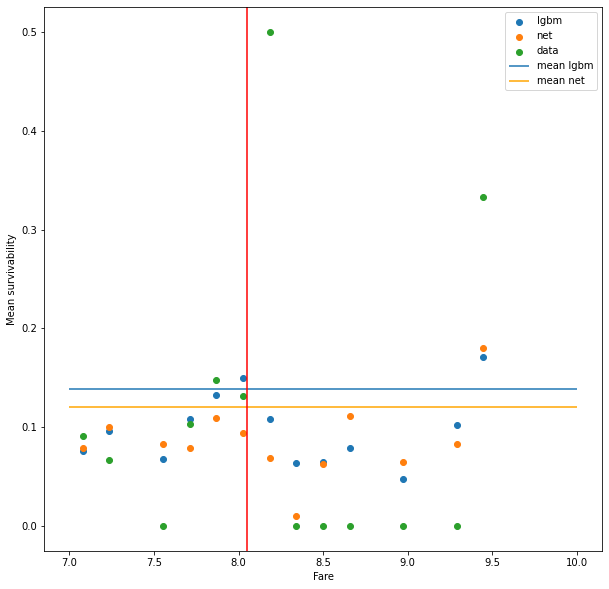

In [235]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(fares, lgbm_means, label='lgbm')
ax.scatter(fares, net_means, label='net')
ax.scatter(fares, survived_means, label='data')
plt.axvline(x=8.05, c='r')
plt.hlines(df_male_3_class.lgbm_pred.mean(), 7, 10, label='mean lgbm')
plt.hlines(df_male_3_class.net_pred.mean(), 7, 10, colors='orange',label='mean net')


ax.set_xlabel('Fare')
ax.set_ylabel('Mean survivability')
ax.legend()
plt.show()

Powyższy wykres przedstawia średnie odpowiedzi modeli i rzeczywistą średnią przeżywalność w grupie mężczyzn z 3 klasy w zależności od ceny biletu. Wraz z prostymi przedstawiającymi średnią odpowiedz modelu w tej grupie. Model oparty na sieci niedoszacowuje średnie prawdopodobieństwo w otoczeniu opłaty wynoszącej 8.05, zaniża prawdopodobieństwo odpowiedzi modelu. Odpowiedź sieci w otoczeniu tej opłaty jest niższa niż średnia opdowiedz sieci, stąd w przypadku sieci atrybucja Fare jest ujemna. W przypadku modelu drzewiatego odpowiedz modelu jest większa niż średnia stąd pozytywny wpływ.